# CO2 level prediction
Atmospheric CO2 from Continuous Air Samples at Mauna Loa Observatory, Hawaii, U.S.A.

https://gml.noaa.gov/ccgg/trends/index.html

In [1]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [78]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import statsmodels.api as sm

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.metrics import mean_squared_error

In [5]:
# link = https://drive.google.com/file/d/131kfaE6K1NQXYG-zrVl_bBwljxPrCpwv/view?usp=drive_link
id = "131kfaE6K1NQXYG-zrVl_bBwljxPrCpwv"
file = drive.CreateFile({'id':id})
file.GetContentFile('co2.csv')

In [12]:
co2_df = pd.read_csv('co2.csv', parse_dates=['date'], index_col='date')
co2_df.head()

,co2
date,
1958-03-29,316.1
1958-04-05,317.3
1958-04-12,317.6
1958-04-19,317.5
1958-04-26,316.4


In [57]:
co2_df.isnull().sum()

,0
co2,59


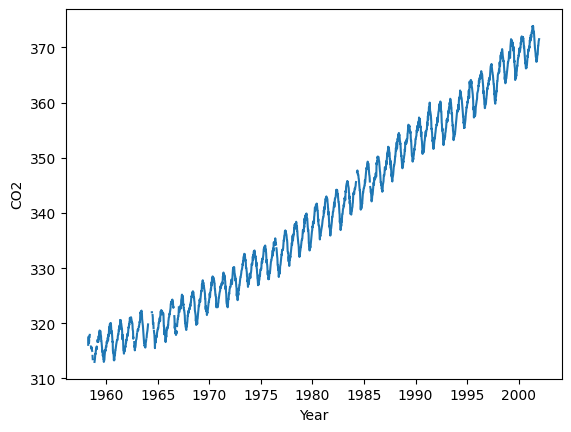

In [14]:
# plt.plot(co2_df)
# plt.xlabel('Year')
# plt.ylabel('CO2')
# plt.show()

In [58]:
y = co2_df['co2'].resample('MS').mean()
y.isnull().sum()

5

In [59]:
y = y.fillna(y.bfill())

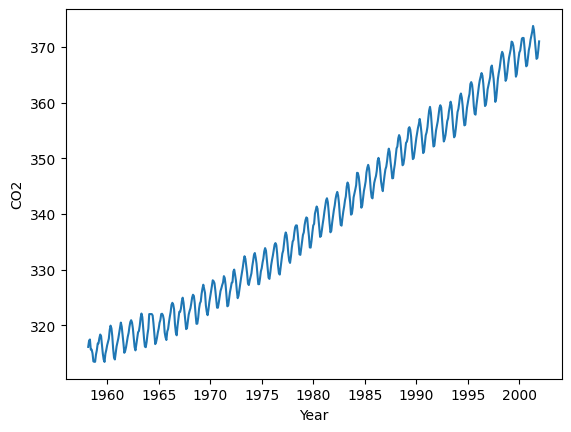

In [60]:
plt.plot(y)
plt.xlabel('Year')
plt.ylabel('CO2')
plt.show()

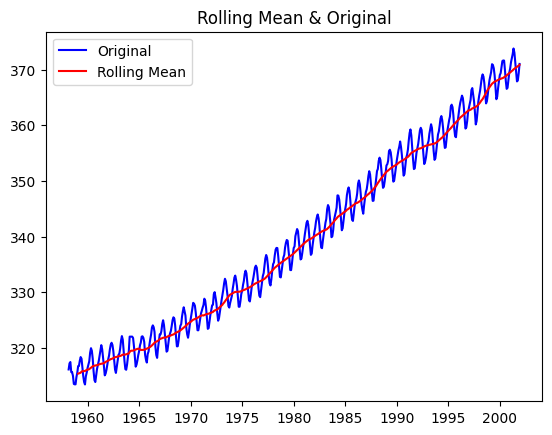

In [61]:
rolling_mean = y.rolling(12).mean()
rolling_std = y.rolling(12).std()
plt.plot(y, color='blue', label='Original')
plt.plot(rolling_mean, color='red', label='Rolling Mean')
plt.title('Rolling Mean & Original')
plt.legend(loc='best')

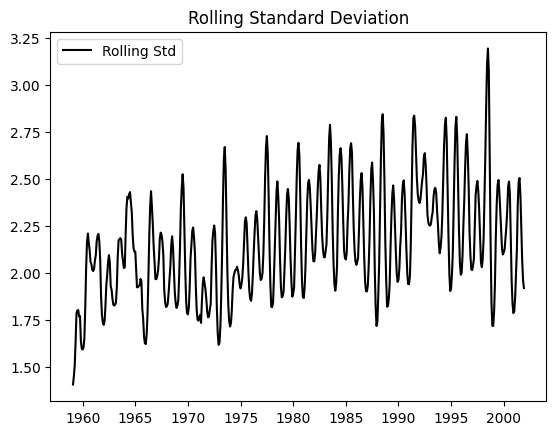

In [62]:
plt.plot(rolling_std, color='black', label='Rolling Std')
plt.title('Rolling Standard Deviation')
plt.legend(loc='best')

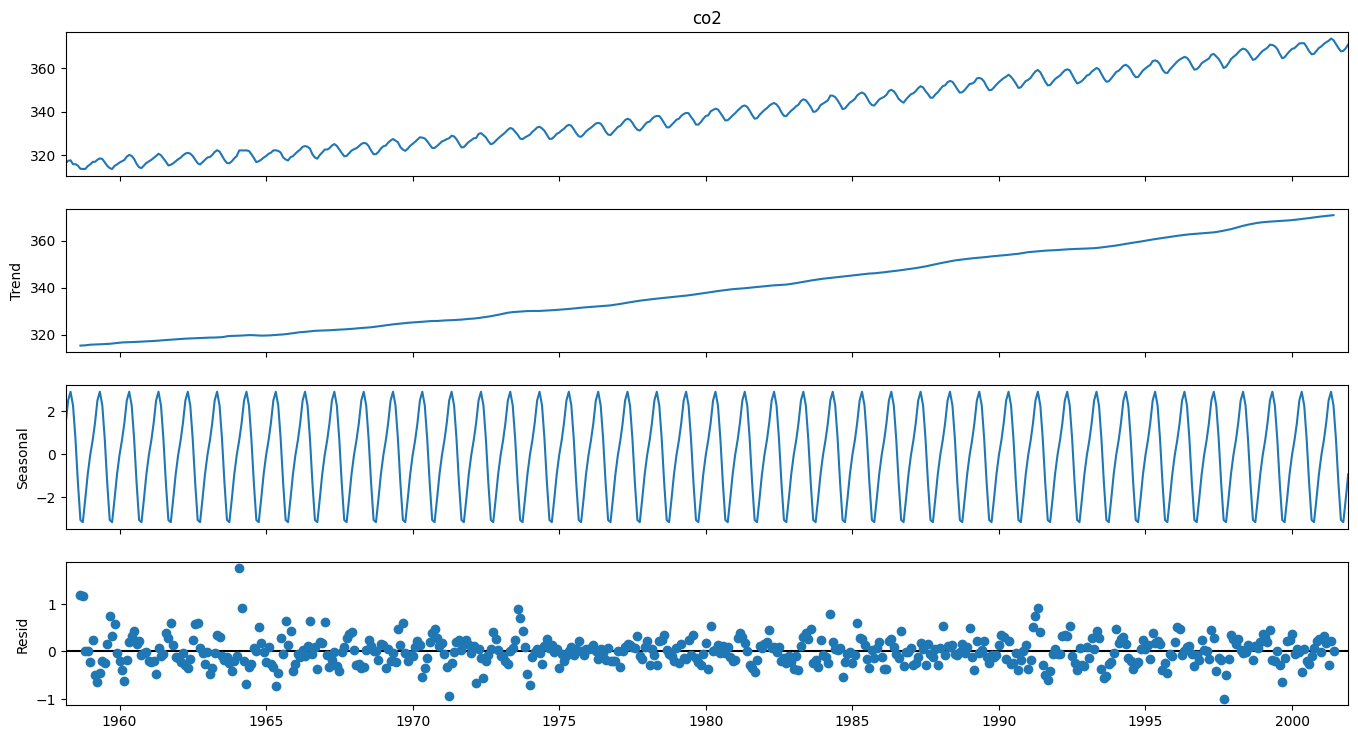

In [63]:
decompose = sm.tsa.seasonal_decompose(y, model='additive')
decompose.plot().set_size_inches(15, 8)
plt.show()

In [64]:
decompose.resid.describe()

,resid
count,514.000000
mean,0.002790
std,0.298683
min,-0.997063
25%,-0.195065
50%,-0.008551
75%,0.166299
max,1.745334


In [65]:
decompose.resid.isnull().sum()

12

In [66]:
resid = decompose.resid
resid = resid.fillna(decompose.resid.bfill())
resid = resid.fillna(decompose.resid.ffill())

In [67]:
resid.describe()

,resid
count,526.000000
mean,0.016137
std,0.320423
min,-0.997063
25%,-0.192372
50%,-0.000486
75%,0.169395
max,1.745334


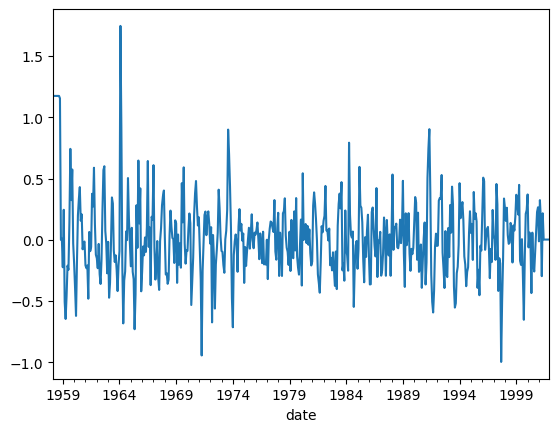

In [68]:
resid.plot()
plt.show()

In [69]:
ADF_residual = sm.tsa.stattools.adfuller(resid)
print('ADF Statistic: %f' % ADF_residual[0])
print('p-value: %f' % ADF_residual[1])
print('Critical Values:')
for key, value in ADF_residual[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -12.181866
p-value: 0.000000
Critical Values:
	1%: -3.443
	5%: -2.867
	10%: -2.570


In [70]:
trend = decompose.trend
trend = trend.fillna(decompose.trend.bfill())
trend = trend.fillna(decompose.trend.ffill())
trend.isnull().sum()

0

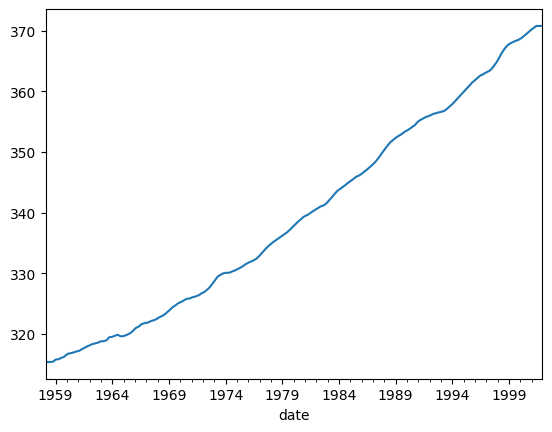

In [71]:
trend.plot()
plt.show()

In [72]:
ADF_trend = sm.tsa.stattools.adfuller(trend)
print('ADF Statistic: %f' % ADF_trend[0])
print('p-value: %f' % ADF_trend[1])
print('Critical Values:')
for key, value in ADF_trend[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: 1.761347
p-value: 0.998269
Critical Values:
	1%: -3.443
	5%: -2.867
	10%: -2.570


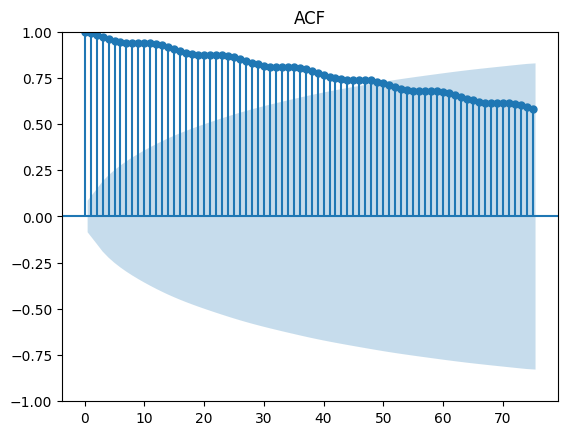

In [73]:
plot_acf(y, lags=75, title='ACF')
plt.show()

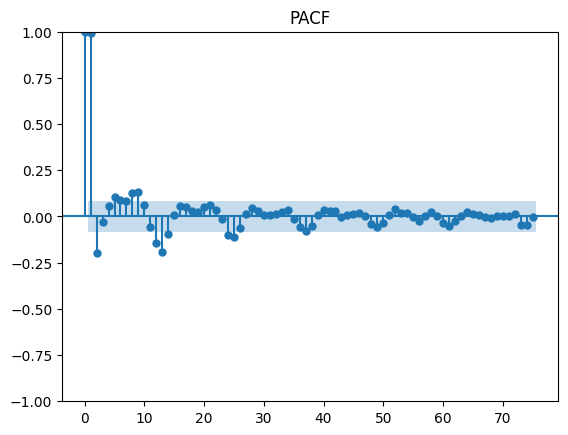

In [74]:
plot_pacf(y, lags=75, title='PACF')
plt.show()

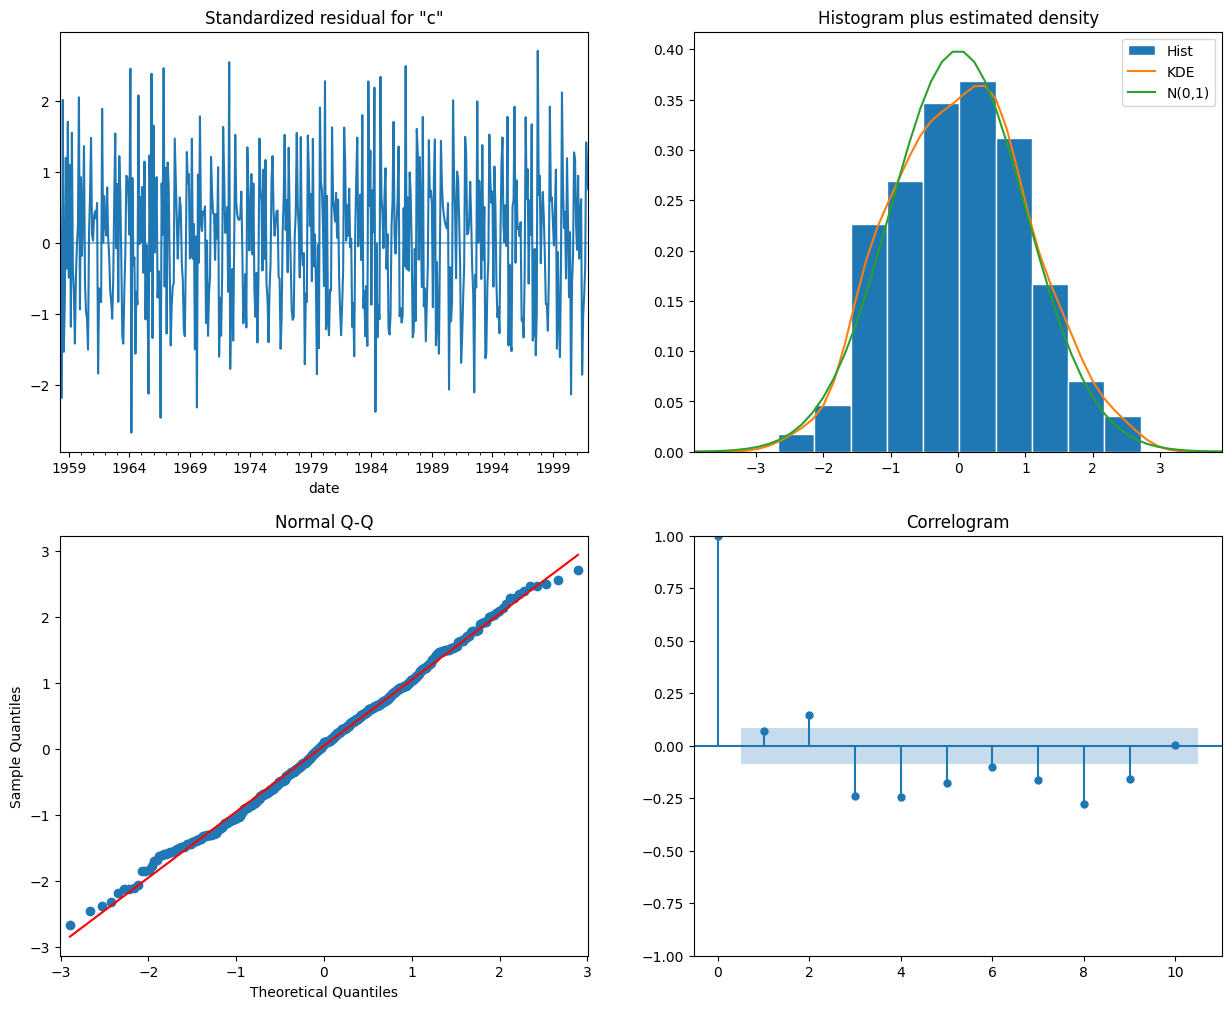

In [83]:
model = sm.tsa.statespace.SARIMAX(y, order=(1, 1, 1))
results = model.fit()
results.plot_diagnostics(figsize=(15, 12))
plt.show()

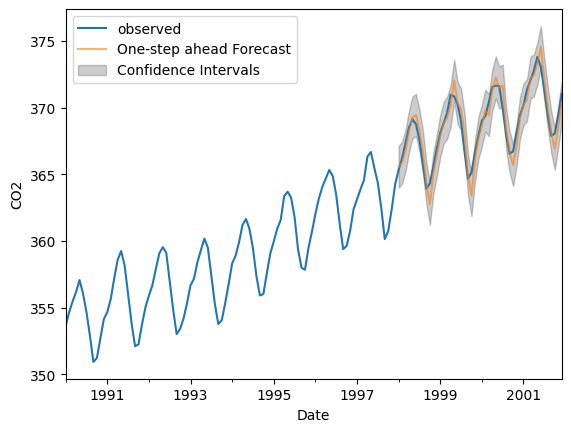

In [93]:
pred = results.get_prediction(start=pd.to_datetime('1998-01-01'), dynamic=False)
pred_conf = pred.conf_int()

ax = y['1990':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.6)
ax.fill_between(pred_conf.index,
               pred_conf.iloc[:, 0],
               pred_conf.iloc[:, 1], color='k', alpha=.2, label='Confidence Intervals')
ax.set_xlabel('Date')
ax.set_ylabel('CO2')
plt.legend()
plt.show()

In [86]:
y_forcast = pred.predicted_mean
y_truth = y['1998-01-01':]
mean_squared_error(y_truth, y_forcast)
print('SARIMA MSE: %.3f' % mean_squared_error(y_truth, y_forcast))

SARIMA MSE: 0.568


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['full_results']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


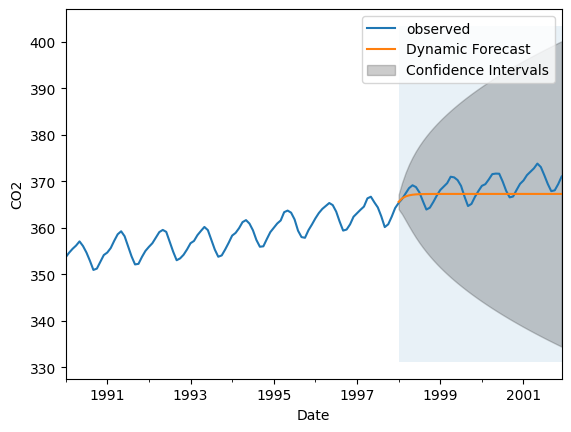

In [87]:
pred_dynamic = results.get_prediction(start=pd.to_datetime('1998-01-01'), dynamic=True, full_results=True)
pred_dynamic_conf = pred_dynamic.conf_int()

ax = y['1990':].plot(label='observed')
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)
ax.fill_between(pred_dynamic_conf.index,
                pred_dynamic_conf.iloc[:, 0],
                pred_dynamic_conf.iloc[:, 1], color='k', alpha=.2, label='Confidence Intervals')
ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('1998-01-01'), y.index[-1],
                 alpha=.1, zorder=-1)
ax.set_xlabel('Date')
ax.set_ylabel('CO2')
plt.legend()
plt.show()